In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns

In [13]:
folder = "/home/compomics/tools/ionbot_paper"
dataset = "PXD001250"

#conditions: "_nort","_nocorr","_nocorr_nort","_closed"
condition = "_nocorr_nort"

In [14]:
#read results open search
ionbot = pd.read_csv("%s/%s/ionbot.first.csv"%(folder,dataset))
ionbot["rank"] = ["first"]*len(ionbot)

tmp = pd.read_csv("%s/%s/ionbot.lower.csv"%(folder,dataset))
tmp["rank"] = ["lower"]*len(tmp)
ionbot = pd.concat([ionbot,tmp])

tmp = pd.read_csv("%s/%s/ionbot.features.csv"%(folder,dataset))
ionbot = ionbot.merge(tmp,on="ionbot_match_id",how="left")

ionbot["PSM"] = ionbot["scan"].astype(str) + ionbot["spectrum_file"] +  "|PSM|" +  ionbot["matched_peptide"]
ionbot["num_matches"] = ionbot.groupby(["spectrum_file","scan"])["scan"].transform("count")
print(ionbot["num_matches"].value_counts())

#read consition results
ionbot_c = pd.read_csv("%s/%s%s/ionbot.first.csv"%(folder,dataset,condition))
ionbot_c["rank"] = ["first"]*len(ionbot_c)

tmp = pd.read_csv("%s/%s%s/ionbot.lower.csv"%(folder,dataset,condition))
tmp["rank"] = ["lower"]*len(tmp)
ionbot_c = pd.concat([ionbot_c,tmp])

tmp = pd.read_csv("%s/%s%s/ionbot.features.csv"%(folder,dataset,condition))
ionbot_c = ionbot_c.merge(tmp,on="ionbot_match_id",how="left")

ionbot_c["PSM"] = ionbot_c["scan"].astype(str) + ionbot_c["spectrum_file"] +  "|PSM|" +  ionbot_c["matched_peptide"]
ionbot_c["num_matches"] = ionbot_c.groupby(["spectrum_file","scan"])["scan"].transform("count")
print(ionbot_c["num_matches"].value_counts())


1    393377
2     44266
3      2262
4        60
Name: num_matches, dtype: int64
1    351019
2     31198
3      1221
4         8
Name: num_matches, dtype: int64


In [15]:
s1 = set(ionbot["PSM"])
s2 = set(ionbot_c["PSM"])

#matches unique to ionbot
s = s1.difference(s2)
ionbot["unique"] = ionbot["PSM"].apply(lambda x: x in s)
print(ionbot["unique"].value_counts())

#matches unique to ionbot_c
s = s2.difference(s1)
ionbot_c["unique"] = ionbot_c["PSM"].apply(lambda x: x in s)
print(ionbot_c["unique"].value_counts())

False    372860
True      67105
Name: unique, dtype: int64
False    372860
True      10586
Name: unique, dtype: int64


<AxesSubplot:xlabel='unique', ylabel='by-intensity-pattern-correlation'>

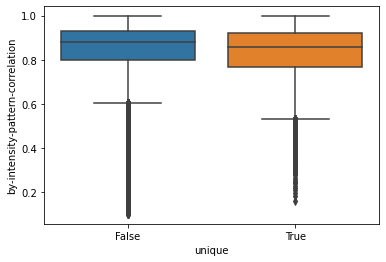

In [18]:
sns.boxplot(x="unique",y="by-intensity-pattern-correlation",data=ionbot)

<AxesSubplot:xlabel='unique', ylabel='by-intensity-pattern-correlation'>

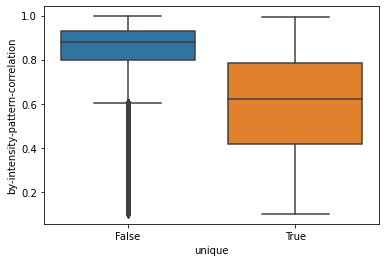

In [19]:
sns.boxplot(x="unique",y="by-intensity-pattern-correlation",data=ionbot_c)

In [25]:
def get_universal_link(x):
    if str(x["modifications"]) == "nan":
        return "http://proteomecentral.proteomexchange.org/usi/?usi=mzspec:%s:%s:scan:%i:%s/%i"%(dataset,x["spectrum_file"],x["scan"],x["matched_peptide"],x["charge"])
    tmp = x["modifications"].split("|")
    seq = list(x["matched_peptide"])
    for i in range(0,len(tmp),2):
        if tmp[i] == "x": #not observed in MS1
            continue
        if tmp[i+1][0] != "[": #mutation
            continue
        mod = int(tmp[i+1].split(']')[0][1:])
        if mod == 4:
            continue
        pos = int(tmp[i])
        seq.insert(pos,"[UNIMOD:%i]"%mod)
    return "http://proteomecentral.proteomexchange.org/usi/?usi=mzspec:%s:%s:scan:%i:%s/%i"%(dataset,x["spectrum_file"],x["scan"],''.join(seq),x["charge"])

ionbot["USI"] = ionbot.apply(get_universal_link,axis=1)